In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize


import tensorflow.keras as ke
import os



import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.layers import Dense, BatchNormalization

import random
from itertools import permutations

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC



import seaborn as sns

%matplotlib inline

In [2]:
#df_normal = pd.read_csv('data_normal_clean.csv', sep = ",")
#df_normal

In [3]:
#df_normal_young = df_normal[df_normal['Group']<=26].copy()
#df_normal_young = df_normal_young.reset_index(drop=True)
#big_group = [[1],[2],[3,4],[5,6],[7,8,9],[10,11,12,13],[14,15,16,17],[18,19,20,21],[22,23,24,25,26]]
#group_dic = {}
#big_group_id = 1
#for group_list in big_group:
#    for i in group_list:
#        group_dic[i] = big_group_id
#    big_group_id+=1

In [4]:
#group_num = df_normal_young['Group'].values
#new_list  = []
#for i in range(len(group_num)):
#    new_list.append(group_dic[int(group_num[i])])
#new_df = pd.DataFrame({'Group': new_list})
#df_normal_young.update(new_df)

In [5]:
epochs = 100
batch_size = 256
logging_step = 5

z_dim = 100
image_shape = (21, 8, 1)
hidden_layer_size = 512

relu_leak = 0.2
init_lr = 0.000001

initializer = ke.initializers.RandomNormal(stddev=0.02)
regularizer = ke.regularizers.l2(2.5e-5)
optimizer = ke.optimizers.Adam(learning_rate=init_lr, beta_1=0.5)

In [6]:
file_path_train = './normal_AllGender/train.csv'
#file_path_test =  './normal_AllGender/valid.csv'
file_path_test =  './normal_AllGender/test.csv'

df_train = pd.read_csv(file_path_train, sep = ',')

# Extract 'Group' and 'Gender' columns
group = df_train['Group'].to_numpy()
gender = df_train['Gender'].to_numpy()

# Combine 'Group' and 'Gender' columns into a single label column
y_train = gender* 10 + group 

df_train = df_train.drop(['Gender'], axis=1)
X_train = df_train.drop(['Group'], axis=1)

X_train = X_train.to_numpy().reshape(X_train.shape[:-1] + image_shape)



df_test = pd.read_csv(file_path_test, sep = ',')

# Extract 'Group' and 'Gender' columns
group = df_test['Group'].to_numpy()
gender = df_test['Gender'].to_numpy()

# Combine 'Group' and 'Gender' columns into a single label column
y_test = gender* 10 + group 


df_test = df_test.drop(['Gender'], axis=1)
X_test = df_test.drop(['Group'], axis=1)

X_test = X_test.to_numpy().reshape(X_test.shape[:-1] + image_shape)

In [7]:
X_train.shape

(21667, 21, 8, 1)

In [8]:
## Extract X by excluding 'Group' and 'Gender' columns
#X = df_normal_young.drop(['Group', 'Gender'], axis=1).to_numpy()

# Reshape X to the new shape
#X = X.reshape(X.shape[:-1] + image_shape)

# Extract 'Group' and 'Gender' columns
#group = df_normal_young['Group'].to_numpy()
#gender = df_normal_young['Gender'].to_numpy()

# Combine 'Group' and 'Gender' columns into a single label column
#y = gender* 10 + group 

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
models_prefix = 'Tmodelsgenderclf100/'
images_prefix = 'Timagesgenderclf100/'

if not os.path.exists(models_prefix):
  os.mkdir(models_prefix)

if not os.path.exists(images_prefix):
  os.mkdir(images_prefix)

In [10]:
def generator():
  model = ke.models.Sequential()
  
  model.add(ke.layers.Dense(hidden_layer_size, input_dim=z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  model.add(ke.layers.BatchNormalization())
  
  model.add(ke.layers.Dense(np.prod(image_shape), activation='sigmoid',
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.Reshape(image_shape))
  
  return model
     

In [11]:
def encoder():
  model = ke.models.Sequential()
  model.add(ke.layers.Flatten(input_shape=image_shape))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  model.add(BatchNormalization()) # workaround
  
  model.add(ke.layers.Dense(z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))

  return model
     

In [12]:
def discriminator():
  z_ = ke.layers.Input(shape=(z_dim,))
  image_ = ke.layers.Input(shape=image_shape)
  input_ = ke.layers.concatenate([z_, ke.layers.Flatten()(image_)])

  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(input_)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  output = ke.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)

  return ke.models.Model([z_, image_], output)

In [13]:
def triplet_loss(y_true, y_pred):
    anchor = y_pred[:, :z_dim]
    positive = y_pred[:, z_dim : z_dim * 2]
    negative = y_pred[:, 2 * z_dim:]

    dist_pos = ke.backend.sum(ke.backend.square(anchor - positive), axis = 1)
    dist_neg = ke.backend.sum(ke.backend.square(anchor - negative), axis = 1)

    loss = dist_pos - dist_neg + 0.3
    
    return ke.backend.maximum(0.0, loss)

In [14]:
def build_T_bigan():
  D = discriminator()
  D.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  D.trainable = False
  
  G = generator()
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)

  image = ke.layers.Input(shape=image_shape)
  image_pos = ke.layers.Input(shape=image_shape)
  image_neg = ke.layers.Input(shape=image_shape)
  
  E = encoder()
  z_ = E(image)
  z_pos = E(image_pos)
  z_neg = E(image_neg)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  triplet = ke.layers.concatenate([z_, z_pos, z_neg])
  
  T_BiGAN = ke.models.Model([z, image, image_pos, image_neg], [D_real, D_fake, triplet])
  T_BiGAN.compile(optimizer=optimizer,
                  loss=['binary_crossentropy', 'binary_crossentropy', triplet_loss])
  
  return G, E, D, T_BiGAN
     

In [15]:
def load_T_bigan(G, E, D):
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)

  image = ke.layers.Input(shape=image_shape)
  image_pos = ke.layers.Input(shape=image_shape)
  image_neg = ke.layers.Input(shape=image_shape)
  
  z_ = E(image)
  z_pos = E(image_pos)
  z_neg = E(image_neg)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  triplet = ke.layers.concatenate([z_, z_pos, z_neg])
  
  T_BiGAN = ke.models.Model([z, image, image_pos, image_neg], [D_real, D_fake, triplet])
  T_BiGAN.compile(optimizer=optimizer,
                  loss=['binary_crossentropy', 'binary_crossentropy', triplet_loss])
  
  return T_BiGAN

In [16]:
def create_triplets(X, y, size = 400): # check 10000 here
  triplets = []
  
  for digit in set(y):
    indices_pos = np.where(y == digit)[0]
    indices_neg = np.where(y != digit)[0]
    
    positives = random.sample(list(permutations(indices_pos, 2)), k = size)
    negatives = random.sample(list(indices_neg), k = size)
    
    for pair in positives:
      anchor = X[pair[0]]
      positive = X[pair[1]]
      
      for idx in negatives:
        negative = X[idx]
        triplets.append([anchor, positive, negative])

  return np.array(triplets)

In [17]:
def qualitative_results(n = 20):
  z = np.random.uniform(-1, 1, (n, z_dim))
  generated = G.predict(z)
  
  real_images = X_test[np.random.choice(len(X_test), n)]
  latent_codes = E.predict(real_images)
  reconstructions = G.predict(latent_codes)
  
  fig, axs = plt.subplots(3, n)
  
  for i in range(n):
    axs[0, i].imshow(generated[i, :, :, 0], cmap='gray')
    axs[1, i].imshow(real_images[i, :, :, 0], cmap='gray')
    axs[2, i].imshow(reconstructions[i, :, :, 0], cmap='gray')
    for j in range(3):
      axs[j, i].axis('off')
  
  return fig
     

In [18]:
def train():
  batches = int(len(X_train) / batch_size)
  
  anchors = triplets[:,0]
  positives = triplets[:,1]
  negatives = triplets[:,2]
  
  ones = np.ones(batch_size)
  zeros = np.zeros(batch_size)
  dummy = np.empty(batch_size)

  for epoch in range(epochs):
    for batch in range(batches):
      indices = np.random.choice(len(triplets), batch_size)
      z = np.random.uniform(-1, 1, (batch_size, z_dim))
      
      images = anchors[indices]
      images_pos = positives[indices]
      images_neg = negatives[indices]
      
      z_ = E.predict(images)
      images_ = G.predict(z)

      loss_D_fake = D.train_on_batch([z, images_], zeros)
      loss_D_real = D.train_on_batch([z_, images], ones)
      loss_T_E_G = T_BiGAN.train_on_batch([z, images, images_pos, images_neg], [zeros, ones, dummy])
      
    if epoch % logging_step == 0:
      D_loss = (loss_D_fake[0] + loss_D_real[0]) * 0.5
      acc_fake = loss_D_fake[1] * 100.0
      acc_real = loss_D_real[1] * 100.0
      loss_E_G = loss_T_E_G[1] + loss_T_E_G[2]
      loss_T   = loss_T_E_G[3]
      
      print('[Epoch {}] (Disc loss: {:.2f}, acc_fake: {:.1f}%, acc_real: {:.1f}%) (E_G loss: {:.2f}) (T loss: {:.3f})'.
            format(epoch, D_loss, acc_fake, acc_real, loss_E_G, loss_T))
      
      fig = qualitative_results()
      fig.savefig(images_prefix + 'T_{}.png'.format(epoch))
      plt.close()

In [19]:
def load_trained_models(models_prefix, encoder, generator, discriminator):
    
    # load weights into new model
    encoder.load_weights(models_prefix + 'T_E_weights.hdf5')

    
    # load weights into new model
    generator.load_weights(models_prefix + 'T_G_weights.hdf5')

    
    # load weights into new model
    discriminator.load_weights(models_prefix  + 'T_D_weights.hdf5')
    
    return encoder, generator, discriminator

In [20]:
LOAD_MODELS = 1

if LOAD_MODELS:
    
  G, E, D, T_BiGAN = build_T_bigan()
  E, G, D = load_trained_models(models_prefix, E, G, D)

#  G = ke.models.load_model(models_prefix + 'T_G.h5')
#  E = ke.models.load_model(models_prefix + 'T_E.h5')
#  D = ke.models.load_model(models_prefix + 'T_D.h5')
  T_BiGAN = load_T_bigan(G, E, D)
    
    
else:
  G, E, D, T_BiGAN = build_T_bigan()

2023-07-19 18:33:19.925406: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 18:33:19.926544: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [21]:
TRAIN_MODELS = 0

if TRAIN_MODELS:
  triplets = create_triplets(X_train, y_train)
  print('Triplets shape: {}'.format(triplets.shape))
  train()

SAVE_MODELS = 0

if SAVE_MODELS:
    G.save_weights(models_prefix + 'T_G_weights.hdf5')
    E.save_weights(models_prefix + 'T_E_weights.hdf5')
    D.save_weights(models_prefix + 'T_D_weights.hdf5')

In [22]:
def ONN_accuracy():
  latent_codes = E.predict(X_test)
  ONN = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(latent_codes)
  
  _, indices = ONN.kneighbors(latent_codes)
  results = (y_test == y_test[indices[:,1]])
  
  print('One Nearest Neighbors (1NN) classification accuracy: {}%'.format(100. * np.mean(results)))

In [24]:
from matplotlib.cm import ScalarMappable
def TSNE_embedding(X, y, n,name):
  latent_codes = E.predict(X[:n])
  embedding = TSNE().fit_transform(latent_codes)
  
  ax = plt.subplot(1, 1, 1)
  #ax.scatter(embedding[:, 0], embedding[:, 1], c=y[:n], cmap=plt.cm.get_cmap('RdYlBu'))
  scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=y[:n], cmap=plt.cm.get_cmap('RdYlBu'))

  # Add a colorbar with class labels
  cbar = plt.colorbar(scatter)
  cbar.set_ticks(range(1,18))  # Set the tick positions
  #cbar.set_ticklabels(y[:n])  # Set the tick labels

  ax.axis('off')


  # Save the graph as a high-resolution TIFF image
  plt.savefig(name + '.tiff', dpi=300)
    
  plt.show()

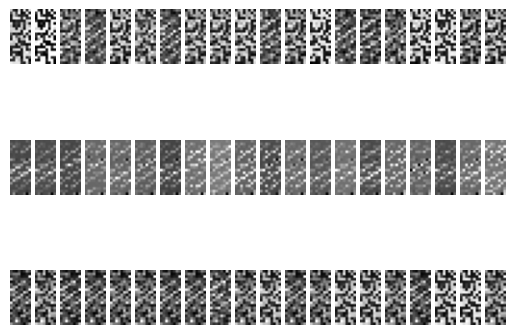

/opt/miniconda3/envs/bigan/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/miniconda3/envs/bigan/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


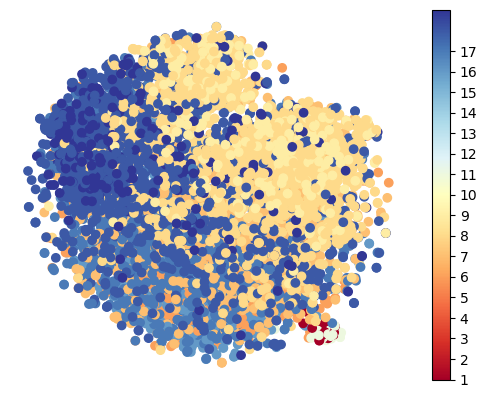

/opt/miniconda3/envs/bigan/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/miniconda3/envs/bigan/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


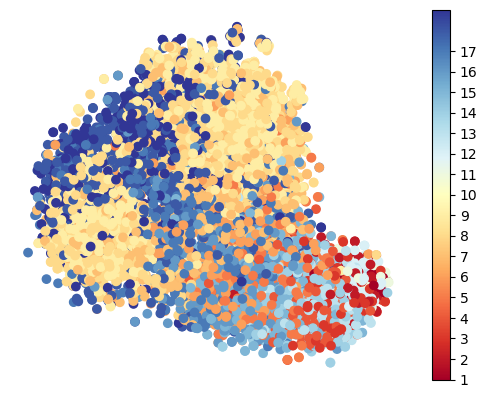

In [25]:
EVALUATE_MODELS = 1

if EVALUATE_MODELS:
  qualitative_results()
  plt.show()
  
  #ONN_accuracy()
    
  
  TSNE_embedding(X_train, y_train, len(y_test),images_prefix + 'TBiGAN'+ 'train')
  TSNE_embedding(X_test, y_test, len(y_test),images_prefix + 'TBiGAN' +'test')

In [26]:
def get_gender_from_y(y):
    gender = y // 10  # Divide by 10 to get the gender
    return gender

In [27]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.svm import SVC

def sgd_classifier(x_train, x_test, y_train, y_test, group, alpha=6e-2):
    # Compute class weights to handle imbalanced data
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

    # Create the model
    #clf = SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced', alpha=alpha, random_state=42, max_iter=1e6, tol=1e-1)

    clf = SVC(class_weight='balanced', kernel='rbf', probability=True, random_state=42, max_iter=1e7, tol=1e-2)

    # Train the model
    clf.fit(x_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(x_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Compute ROC curve and AUC
    y_prob = clf.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = {:.2f}, F1 Score = {:.2f})'.format(roc_auc, f1))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    # Save the graph as a high-resolution TIFF image (optional)
    
    
    name = images_prefix + 'TBiGANROC' + str(group)
    plt.savefig(name + '.tiff', dpi=300)
    
    plt.show()


In [29]:
def split_X_by_similar_group(X, y):
    groups = get_group_from_y(y)  # Assuming you have a function get_group_from_y(y) that returns the group for each y value
    
    # Create lists to store the arrays for each group
    Xs = []
    ys = []
    
    # Iterate over the unique groups and split X and y accordingly
    for group in set(groups):
        mask = groups == group
        X_group = X[mask]
        y_group = y[mask]
        Xs.append(X_group)
        ys.append(y_group)
    
    return Xs, ys

In [31]:
def get_group_from_y(y):
    group = y % 10  # reminder to 10 to get the group
    return group

In [33]:
def get_gender_from_y(y):
    gender = y // 10  # Divide by 10 to get the gender
    return gender

In [32]:
X_trains,y_trains = split_X_by_similar_group(X_train,y_train)
X_tests,y_tests = split_X_by_similar_group(X_test,y_test)

Accuracy: 0.6567164179104478


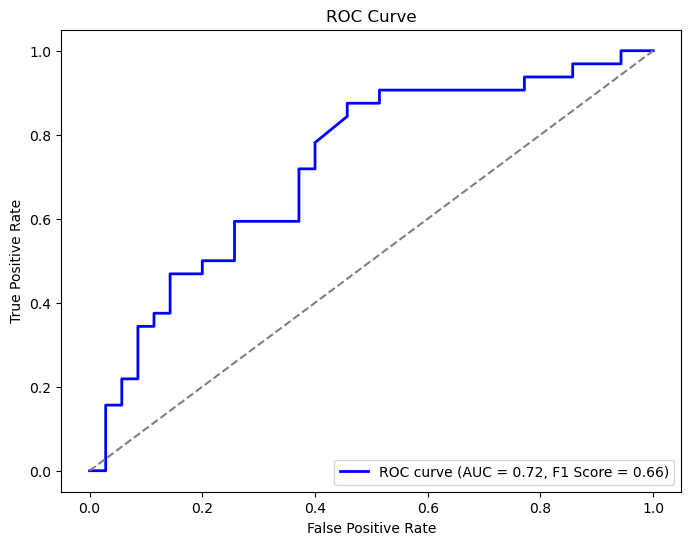

Accuracy: 0.5555555555555556


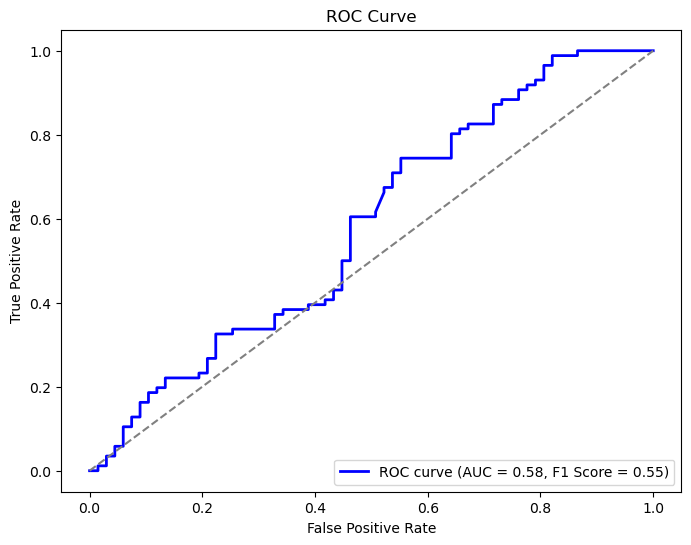

Accuracy: 0.6344086021505376


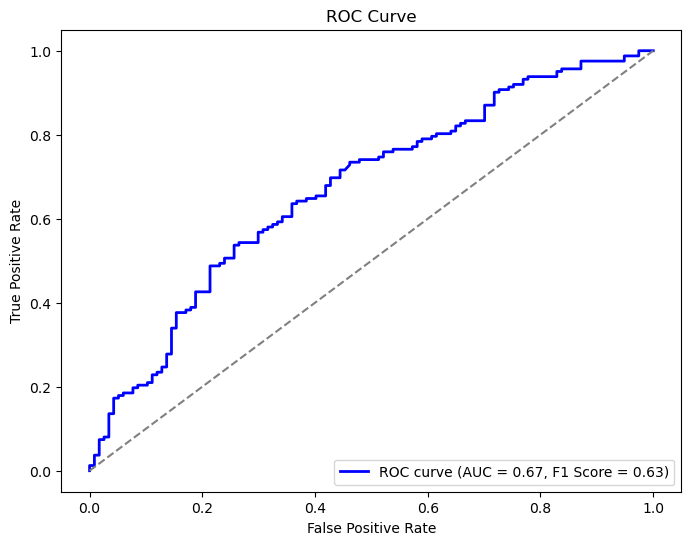

Accuracy: 0.6118980169971672


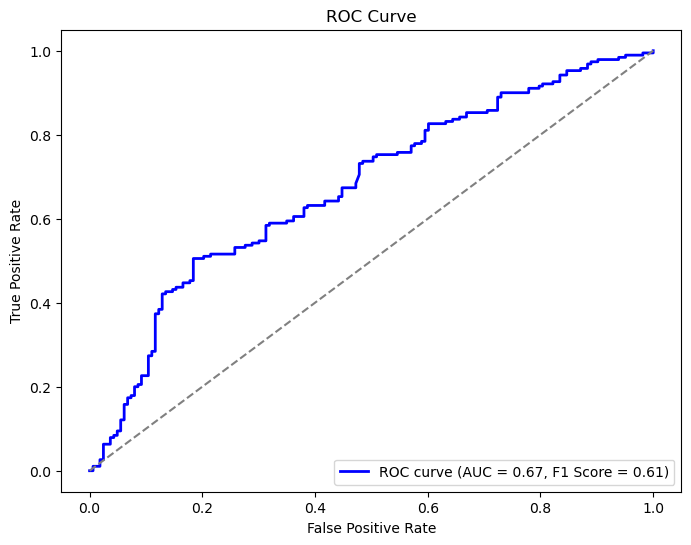

Accuracy: 0.6707317073170732


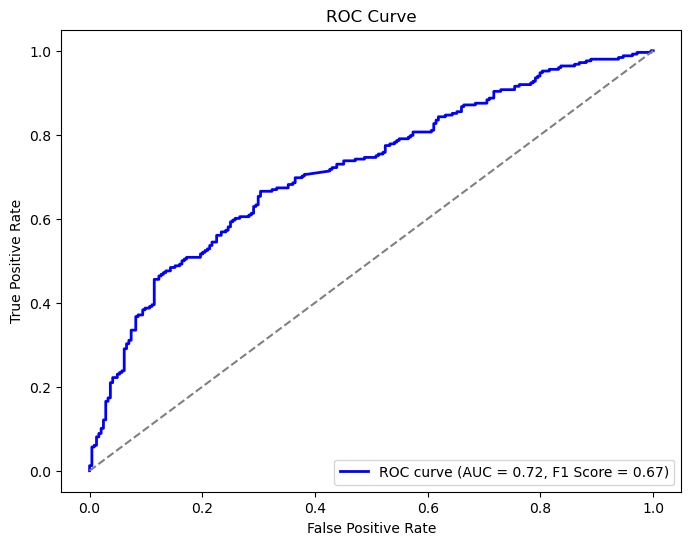

Accuracy: 0.6435643564356436


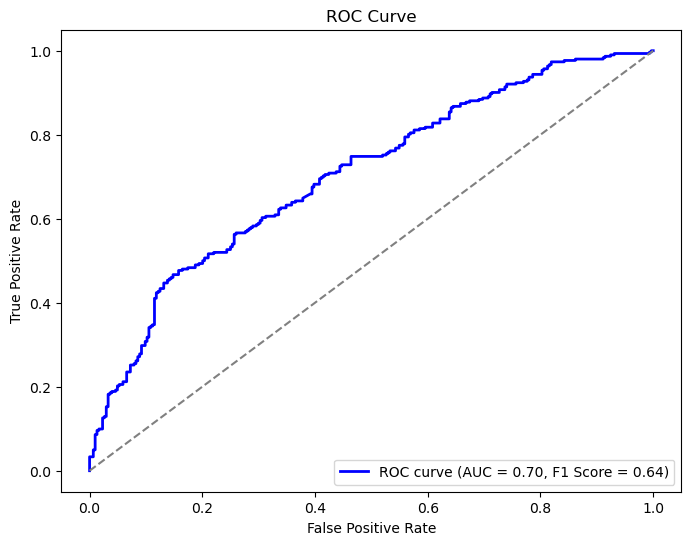

Accuracy: 0.7268722466960352


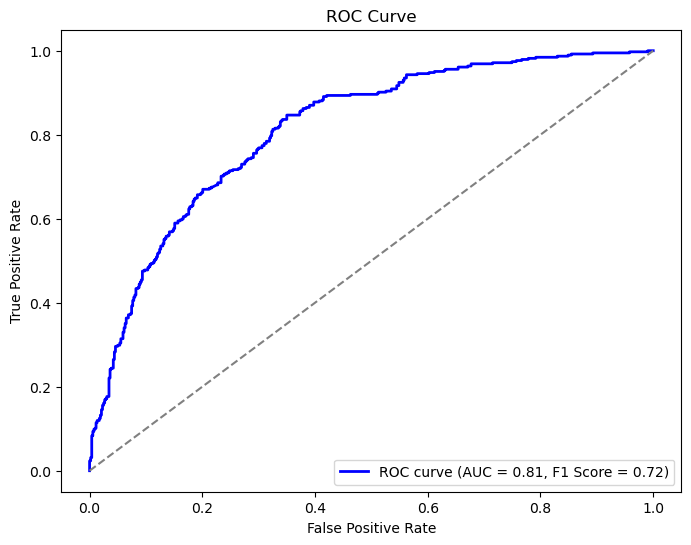

Accuracy: 0.852328431372549


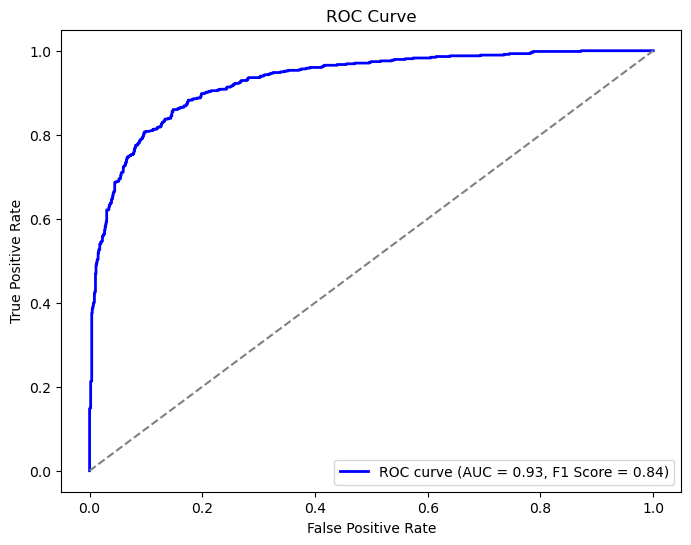

Accuracy: 0.8579842931937173


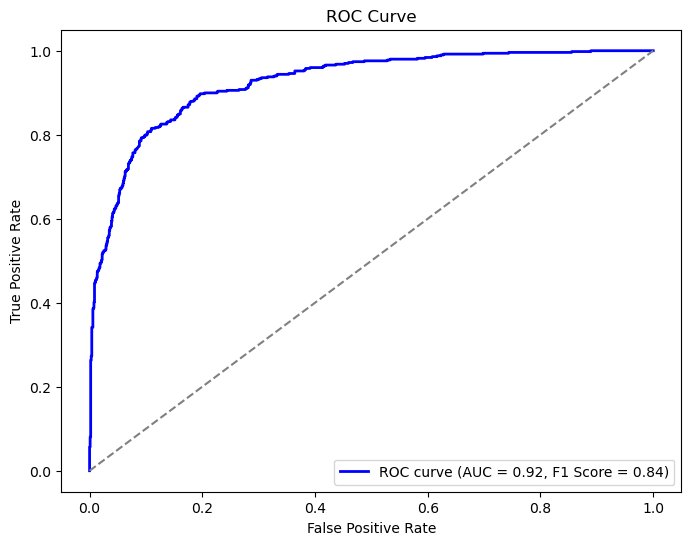

In [34]:
group = 1
for Xg_train, Xg_test, yg_train, yg_test in zip(X_trains, X_tests, y_trains, y_tests):
    M = Xg_train.shape[0]
    N = Xg_test.shape[0]
    #print(group,M,N)
    
    sgd_classifier(E.predict(Xg_train.reshape(M,21,8,1))\
                   , E.predict(Xg_test.reshape(N,21,8,1))\
                   , get_gender_from_y(yg_train)\
                   , get_gender_from_y(yg_test), group)
    group += 1

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.svm import SVC

def svm_classifier(x_train, x_test, y_train, y_test, group, alpha=6e-2):
    # Compute class weights to handle imbalanced data
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

    # Create the model
    #clf = SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced', alpha=alpha, random_state=42, max_iter=1e6, tol=1e-1)

    clf = SVC(class_weight='balanced', kernel='rbf', probability=True, random_state=42, max_iter=1e7, tol=1e-2)

    # Train the model
    clf.fit(x_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(x_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Compute ROC curve and AUC
    y_prob = clf.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label='SVM (AUC = {:.2f}, F1 Score = {:.2f})'.format(roc_auc, f1))
    
    
    
    
    
    #################.  TBiGAN ##########################
    clf1 = SVC(class_weight='balanced', kernel='rbf', probability=True, random_state=42, max_iter=1e7, tol=1e-2)

    # Train the model
    M = x_train.shape[0]
    N = x_test.shape[0]
    clf1.fit(E.predict(x_train.reshape(M,21,8,1)), y_train)

    # Predict on the test set
    y_pred = clf1.predict(E.predict(x_test.reshape(N,21,8,1)))

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Compute ROC curve and AUC
    y_prob = clf1.predict_proba(E.predict(x_test.reshape(N,21,8,1)))
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])

    # Plot the ROC curve
    #plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='g', lw=2, label='TBiGAN (AUC = {:.2f}, F1 Score = {:.2f})'.format(roc_auc, f1))
    
    
    
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    # Save the graph as a high-resolution TIFF image (optional)
    
    
    name = images_prefix + 'TBiGANSVMROC' + str(group)
    plt.savefig(name + '.tiff', dpi=300)
    
    plt.show()


Accuracy: 0.7164179104477612
Accuracy: 0.6567164179104478


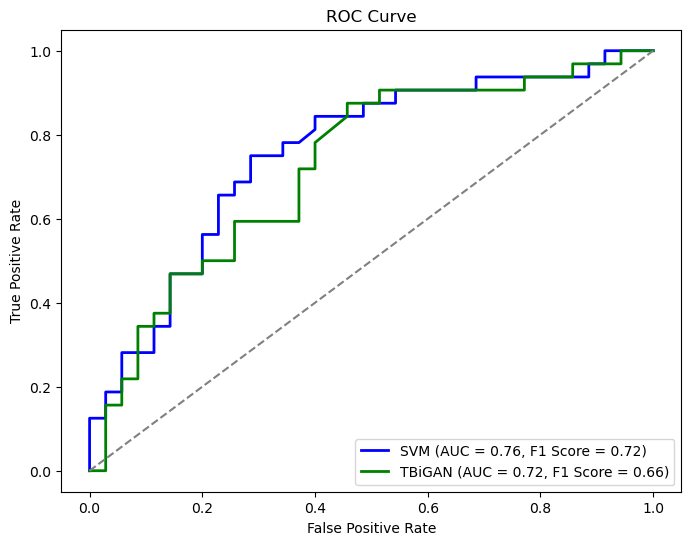

Accuracy: 0.5686274509803921
Accuracy: 0.5555555555555556


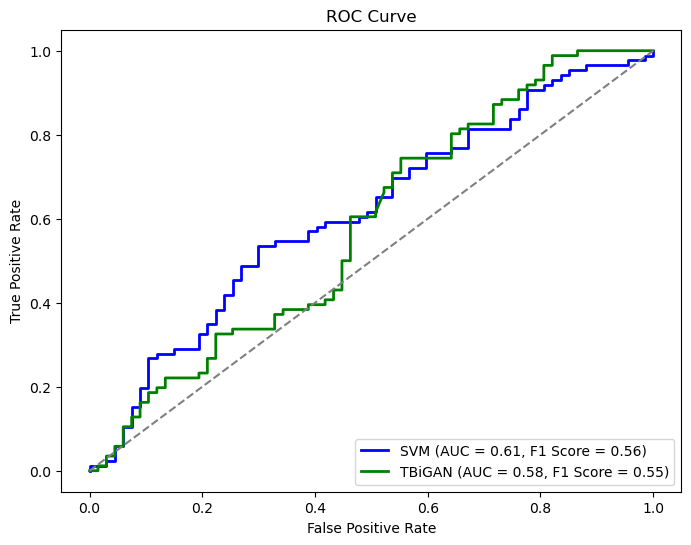

Accuracy: 0.6057347670250897
Accuracy: 0.6344086021505376


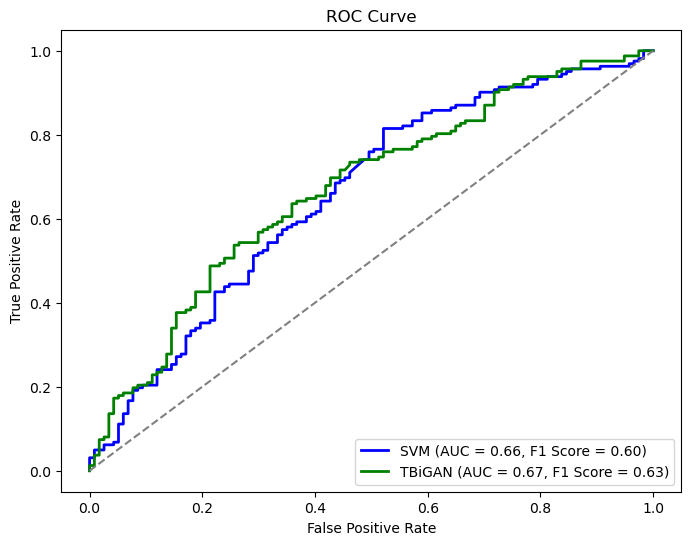

Accuracy: 0.5779036827195467
Accuracy: 0.6118980169971672


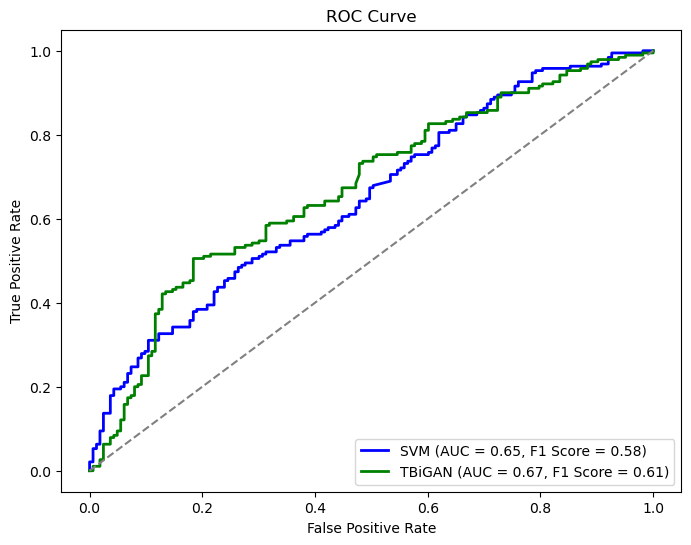

Accuracy: 0.6382113821138211
Accuracy: 0.6707317073170732


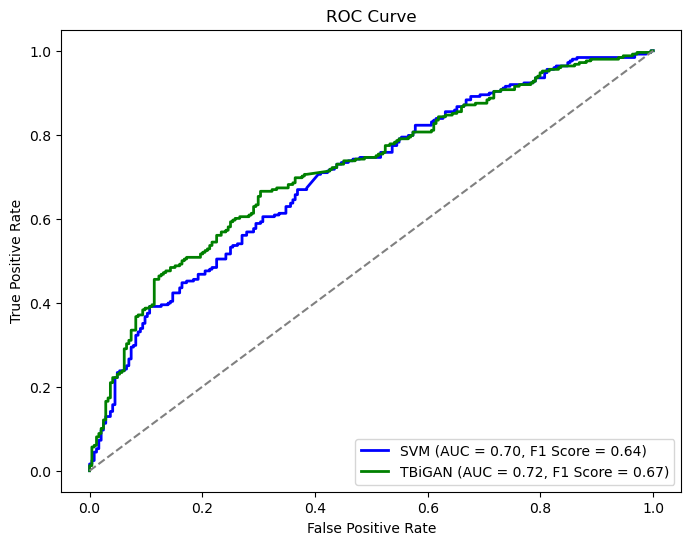

Accuracy: 0.6600660066006601
Accuracy: 0.6435643564356436


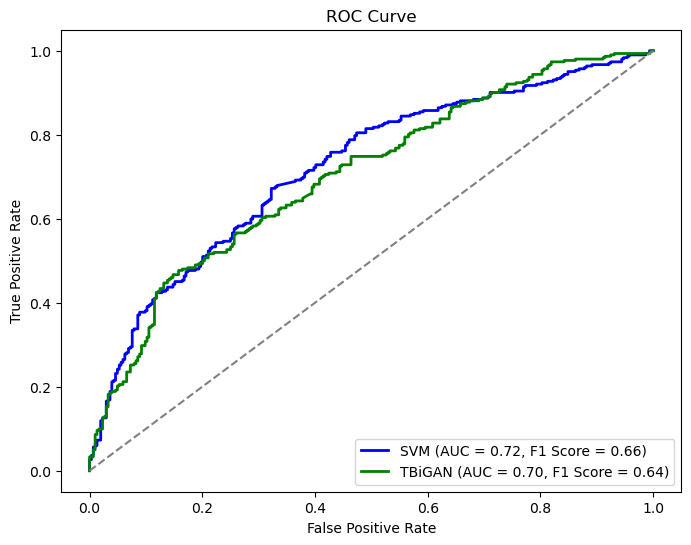

Accuracy: 0.7533039647577092
Accuracy: 0.7268722466960352


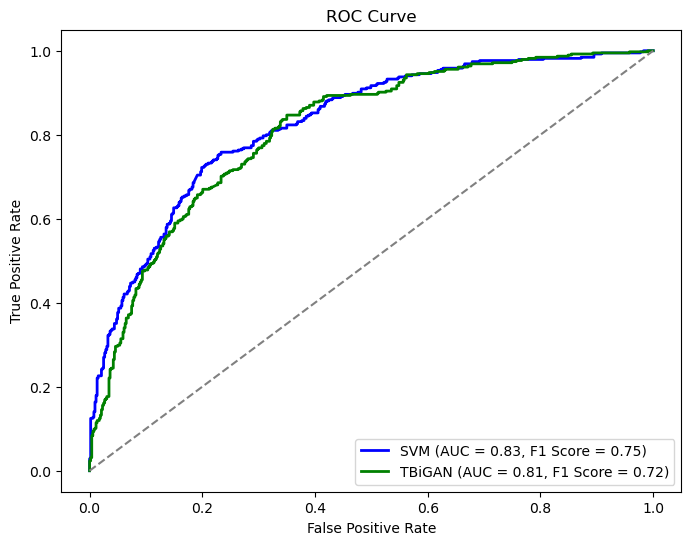

Accuracy: 0.8590686274509803
Accuracy: 0.852328431372549


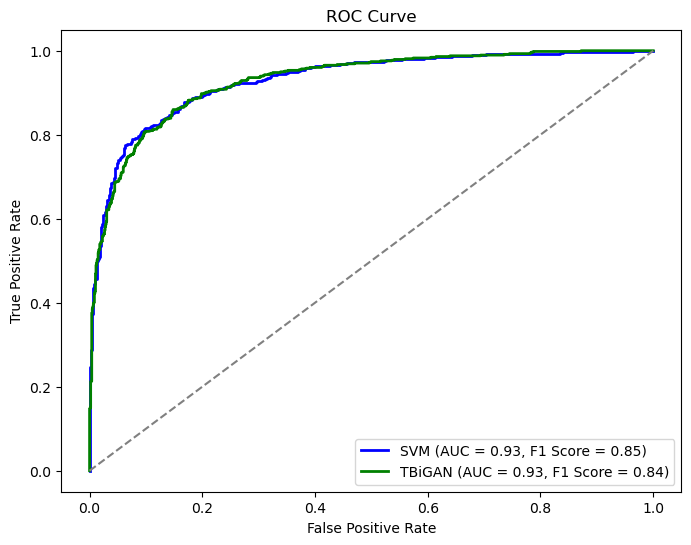

Accuracy: 0.8619109947643979
Accuracy: 0.8579842931937173


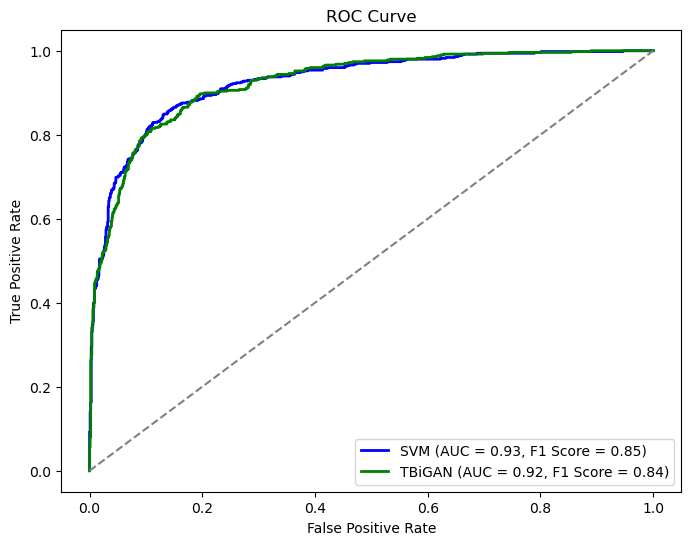

In [47]:
group = 1
for Xg_train, Xg_test, yg_train, yg_test in zip(X_trains, X_tests, y_trains, y_tests):
    M = Xg_train.shape[0]
    N = Xg_test.shape[0]
    #print(group,M,N)
    
    svm_classifier(Xg_train.reshape(M,168)\
                   , Xg_test.reshape(N,168)\
                   , get_gender_from_y(yg_train)\
                   , get_gender_from_y(yg_test), group)
    group += 1